# DeleteMessages

- Author: [Suhyun Lee](https://github.com/suhyun0115)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

In LangChain, you can not only add messages but also delete them when necessary. The `RemoveMessage` tool is used for this purpose.

This tool sends a deletion request for a specific message. The deletion is then processed according to the `reducer` rules defined in `MessagesState`.

In essence, `RemoveMessage` initiates the deletion, the `reducer` determines how those requests are processed, and `MessagesState` serves as the storage and the management system for messages.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Building a Basic LangGraph](#building-a-basic-langgraph)
- [Manual Deletion of Messages](#manual-deletion-of-messages)
- [Dynamic Deletion of Messages](#dynamic-deletion-of-messages)

### References

- [LangChain](https://blog.langchain.dev/)
- [How to delete messages](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langchain_anthropic",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "DeleteMessages",  # set the project name same as the title
        }
    )

## Building a Basic LangGraph

LangGraph offers a powerful way to design workflows that integrate message state management and tool invocation. This section demonstrates the basic process of constructing a LangGraph.

**Key Components**
1. `MemorySaver`: A memory object for saving checkpoints, allowing you to save and restore conversation states.
2. `ToolNode`: A node for executing custom tools. In this tutorial, it includes a `search` tool that simulates a web search.
3. `MessagesState`: Stores and updates message states, serving as the central hub for state-based workflows.
4. `StateGraph`: A graph object that defines the state-based workflow, controlling the flow of execution between nodes and edges.
5. `should_continue`: A conditional function that determines the next node to execute based on the current statue of the agent.

**Key Workflow Details**

**Defining and Registering Tools:**
- The `search` function simulates a web search and returns results for a given query.
- This tool is then wrapped in a `ToolNode` and integrated into the LangGraph.

**Model Initialization and Binding:**
- Initialize an LLM model, such as `ChatOpenAI` , and bind it with tools to ensure they can be executed during runtime.

**Defining the Workflow:**
- The `StateGraph` is used to define the workflow by adding nodes and connecting them with edges.
- The workflow begins at the `START` node. The `agent` is executed first, calling tools as needed, and then control returns to the agent.

**Conditional Flow Control:**
- The `should_continue` function checks the state of the last message to determine whether a tool should be executed or the workflow should terminate.

In [4]:
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Initialize a memory object for checkpoint saving
memory = MemorySaver()


# Define a tool function mimicking a web search feature
@tool
def search(query: str):
    """Call to surf on the web."""
    return "Web search result: You can find the LangGraph tutorial at https://langchain-ai.github.io/langgraph/."


# Create a list of tools and initialize a tool node
tools = [search]
tool_node = ToolNode(tools)

# Initialize a model and bind tools. You can select models like GPT or Claude
model = ChatOpenAI(model_name="gpt-4o-mini")
# model = ChatAnthropic(model="claude-3-5-sonnet-20240620") # if you use Claude
bound_model = model.bind_tools(tools)


# Determine the next execution node based on the conversation state
def should_continue(state: MessagesState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return END
    return "tool"


# Function to call the LLM model and handle its response
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Initialize a workflow graph based on the state
workflow = StateGraph(MessagesState)

# Add agent and action nodes
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# Set the starting point as the agent node
workflow.add_edge(START, "agent")

# Set conditional edges: define the execution flow after the agent node
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# Add an edge to return from the tool to the agent
workflow.add_edge("tool", "agent")

# Compile the final executable workflow including the checkpointer
app = workflow.compile(checkpointer=memory)

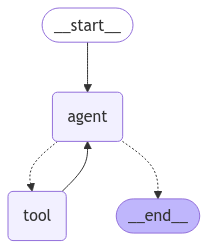

In [5]:
# Visualize the graph
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage

# Initialize configuration object with thread ID 1
config = {"configurable": {"thread_id": "1"}}

# First question execution
input_message = HumanMessage(content="I like chocolate more than candy.")

# Process the message in stream mode and print the response details of the last message
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I like chocolate more than candy.
================================== Ai Message ==================================

That's a common preference! Many people enjoy the rich, creamy taste of chocolate more than the often sweeter and more varied flavors of candy. Do you have a favorite type of chocolate, like dark, milk, or white?


The following code snippet, `for event in app.stream({"messages": [input_message]}, config, stream_mode="values")`, operates as follows: 

1. **Calling `app.stream()`:**
- This initiates the workflow and streams each event.
- Parameters:
   - `{"messages": [input_message]}`: Sets the initial message for the workflow.
   - `config`: Contains configuration values, including `thread_id` set to `"1"` .
   - `stream_mode="values"`: Specifies the streaming mode as value-based.

2. **Loop Behavior:**
- The loop iterates through each event generated by the workflow.
- Event details:
   - `event["messages"][-1]`: Retrieves the most recent message.
   - `pretty_print()`: Prints the retrieved message.

Key Streaming Modes of `app.stream()`:

1. **`values` Mode**
- This mode receives the entire state of the graph after each node execution.
- Suitable for basic state monitoring.
- **Example:** Receiving the complete response from an LLM after it finishes its response.

2. **`updates` Mode**
- This mode receives only the changes made to the state after each node execution.
- Useful for efficient state management.
- **Example:** Receiving only the newly added content compared to the previous state.

3. **`messages` Mode**
- This mode provides the most detailed, real-time information.
- Ideal for real-time applications, such as chatbots.
- **Example:** Observing the step-by-step "thought process" of an LLM in real-time. For instance, "Thinking..." → "Chocolate is..." → "a delicious snack."

In [7]:
# Follow-up question execution
input_message = HumanMessage(content="What is my favorite snack?")

# Process the second message in stream mode and print the response
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

Based on your previous message, it seems like chocolate might be your favorite snack! However, if you have other snacks you enjoy, I'd love to hear about them!


In [8]:
# Step-by-Step Status Check
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

I like chocolate more than candy.
================================== Ai Message ==================================

That's a common preference! Many people enjoy the rich, creamy taste of chocolate more than the often sweeter and more varied flavors of candy. Do you have a favorite type of chocolate, like dark, milk, or white?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

Based on your previous message, it seems like chocolate might be your favorite snack! However, if you have other snacks you enjoy, I'd love to hear about them!


### Deleting Messages

There are two primary methods for deleting messages within a LangGraph workflow: **Manual Deletion** and **Dynamic Deletion** . Let's take a closer look at each method.

## Manual Deletion of Messages

This section demonstrates how to manually retrieve message logs from the LangGraph workflow, delete specific messages, and then update the graph's state. This process enables effective message management and conversation record manipulation.

**Key Steps for Manual Deletion**
1. **Message Retrieval:**
- Use the `app.get_state(config)` method to extract the list of messages from the current state.
- Use `pretty_print()` method to display each message in a user-friendly format.

2. **Message Deletion:**
- Utilize a `RemoveMessage` object, specifying the ID of the message to delete.
- The code example demonstrates removing the first message in the array.

3. **State Update:**
- Use the `app.update_state(config, ...)` method to apply the deletion and update the graph's state.
- After the update, retrieve and display the message list again to verify the deletion.

**Code Flow**
1. **Output Stored Messages:**
- Retrieve the messages from the current state using `messages = app.get_state(config).values["messages"]`.
- Iterate through the `messsages` list and print each message to review the current conversation history.

2. **Delete a Specific Message:**
- Use `RemoveMessage(id=messages[0].id)` to create a delete request for the first message.
- Update the graph's state using `app.update_state(config, ...)` to reflect the deletion.

3. **Output Updated Messages:**
- After updating the state, retrieve the updated message list and print it to confirm the deletion.

In [9]:
# Extracting Message List in App State and Viewing Saved Conversation History
messages = app.get_state(config).values["messages"]

for message in messages:
    message.pretty_print()

================================ Human Message =================================

I like chocolate more than candy.
================================== Ai Message ==================================

That's a common preference! Many people enjoy the rich, creamy taste of chocolate more than the often sweeter and more varied flavors of candy. Do you have a favorite type of chocolate, like dark, milk, or white?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

Based on your previous message, it seems like chocolate might be your favorite snack! However, if you have other snacks you enjoy, I'd love to hear about them!


In [10]:
from langchain_core.messages import RemoveMessage

# Remove the First Message from the Message Array by ID and Update the App State
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

# Extracting Message List from App State and Retrieving Saved Conversation History
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

That's a common preference! Many people enjoy the rich, creamy taste of chocolate more than the often sweeter and more varied flavors of candy. Do you have a favorite type of chocolate, like dark, milk, or white?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

Based on your previous message, it seems like chocolate might be your favorite snack! However, if you have other snacks you enjoy, I'd love to hear about them!


## Dynamic Deletion of Messages

Dynamic deletion automates the process of deleting older messages during workflow execution, ensuring that only the most recent messages are retained.

**Key Components for Dynamic Deletion**

1. `delete_messages(state: dict) -> dict`:
- This function implements the logic for deleting old messages when it checks if the number of messages exceeds a specific limit (e.g., 3). It retains only the latest ones.

2. `should_continue(state: dict) -> str`:
- This conditional function determins the next node to execute based on the current state.
- If there is no function call in the current messages, the workflow proceeds to the `delete_messages` node. If a function call exists, the workflow proceeds to the `action` node.

3. `StateGraph`: Defines the state-based workflow, connecting the `agent`, `action`, and `delete_messages` nodes with appropriate edges.

**Key Details**

**Message Management:**
- The `delete_messages` function manages the message state by removing older messages during prolonged conversations, thus maintaining memory efficiency.

**Conditional Flow Control:**
- The `should_continue` function inspects the state of the last message to determine if a tool call is required. This determines the next node in the execution flow.

**Workflow Definition:**
- The `StateGraph` defines the workflow by adding nodes for `agent`, `action`, and `delete_messages` nodes.
- Each node is configured to follow the appropriate flow based on state and conditions.

**Memory Checkpoint Integration:**
- The `MemorySaver` object allows for saving and restoring checkpoints, enabling seamless compilation and resumption of the workflow.

In [11]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END


# If the number of messages exceeds 3, delete older messages and retain only the latest ones
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# Logic to determine the next execution node based on the message state
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # Execute the message deletion function if no tool calls are present
    if not last_message.tool_calls:
        return "delete_messages"
    # Execute an action if tool calls are present
    return "action"


# Define the workflow graph based on the message state
workflow = StateGraph(MessagesState)

# Add agent and action nodes
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Add the message deletion node
workflow.add_node(delete_messages)

# Connect the start node to the agent node
workflow.add_edge(START, "agent")

# Control flow between nodes by adding conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# Connect the action node back to the agent node
workflow.add_edge("action", "agent")

# Connect the message deletion node to the end node
workflow.add_edge("delete_messages", END)

# Compile the workflow using a memory checkpoint
app = workflow.compile(checkpointer=memory)

**Process Flow**

1. The workflow starts at the `START` node and executes the `agent` node.
2. The `should_continue` function then determines the next node based on the current state:
- If no function call is present in the messages, the workflow proceeds to the `delete_messages` node. 
- If a function call is present, the workflow proceeds to the `action` node.
3. Each node transitions to the next execution path based on the defined conditions.
4. The `delete_message` node then connects to the `END` node, terminating that branch of the workflow.

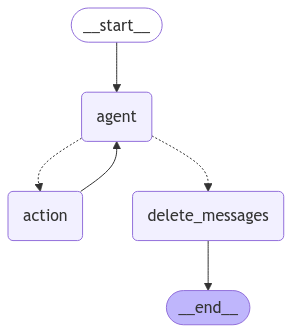

In [12]:
# Dynamic Deletion Visualization
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Import the HumanMessage class for LangChain message processing
from langchain_core.messages import HumanMessage

# Initialize a configuration object with a thread ID
config = {"configurable": {"thread_id": "2"}}

# Perform the first query
input_message = HumanMessage(content="I like chocolate more than candy.")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', 'I like chocolate more than candy.')]
[('human', 'I like chocolate more than candy.'), ('ai', "That's a popular preference! Chocolate has a rich, creamy texture and comes in various forms, from dark to milk to white, along with countless flavor combinations. Do you have a favorite type of chocolate or a specific treat that you enjoy?")]


In [ ]:
# Perform the second query
input_message = HumanMessage(content="What is my favorite snack?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', 'I like chocolate more than candy.'), ('ai', "That's a popular preference! Chocolate has a rich, creamy texture and comes in various forms, from dark to milk to white, along with countless flavor combinations. Do you have a favorite type of chocolate or a specific treat that you enjoy?"), ('human', 'What is my favorite snack?')]
[('human', 'I like chocolate more than candy.'), ('ai', "That's a popular preference! Chocolate has a rich, creamy texture and comes in various forms, from dark to milk to white, along with countless flavor combinations. Do you have a favorite type of chocolate or a specific treat that you enjoy?"), ('human', 'What is my favorite snack?'), ('ai', 'Based on your previous statement, it seems that your favorite snack might be chocolate! If you have other snacks you enjoy, feel free to share!')]
[('ai', "That's a popular preference! Chocolate has a rich, creamy texture and comes in various forms, from dark to milk to white, along with countless flavor co

**Final State:** Because messages are automatically deleted when the count exceeds 3, only the 3 most recent messages are retained in the final state.

In [15]:
# Extract and save the message list from the app state
messages = app.get_state(config).values["messages"]

# Return the message list
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

That's a popular preference! Chocolate has a rich, creamy texture and comes in various forms, from dark to milk to white, along with countless flavor combinations. Do you have a favorite type of chocolate or a specific treat that you enjoy?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

Based on your previous statement, it seems that your favorite snack might be chocolate! If you have other snacks you enjoy, feel free to share!
